In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm
# import ttach as tta

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

##내가 사용할 모델정보 py파일 import해야된다 + 데이터로더도 같이
from dataloader import *
# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_path = "/opt/ml/input/data/test.json"

test_transform = A.Compose([
#                             A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.2, p=0.5),
                           ToTensorV2() 
])


test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)
test_loader = DataLoader(
        test_dataset,
        batch_size=8,
        num_workers=4,
        shuffle=False,
        collate_fn=collate_fn,
    )

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [5]:
import segmentation_models_pytorch as smp
import torch 
from importlib import import_module


def myModel(seg_model, encoder_name='timm-efficientnet-b4' ):
    smp_model =getattr(smp,seg_model)
    model =  smp_model(
        encoder_name=encoder_name,
        encoder_depth=5, 
        encoder_weights='noisy-student',
        decoder_use_batchnorm=True, 
        # decoder_channels=(1024, 512, 256, 128, 64), 
        decoder_channels=(512, 256, 128, 64, 32), 
        decoder_attention_type=None, 
        in_channels=3, 
        classes=11, 
        activation=None, 
        aux_params=None
    )
    return model


In [6]:
model_path = './test/GR-timm-efficientnetb4-lr-test2/best.pth'
checkpoint = torch.load(model_path, map_location=device)
model = myModel("UnetPlusPlus","timm-efficientnet-b4")
model = model.to(device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [7]:
def test(model, data_loader, device):
    #### 슈도할때는 512
    #### 그냥 라벨링 할때는 256
    size = 256
    transform = A.Compose([A.Resize(size, size)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
            
            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)
                
            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    
    return file_names, preds_array

In [8]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

##### image name을 npy로 저장
#### 슈도 라벨링할때만 사용
'''
name_list = []
for i in file_names:
    name_list.append(i)
np.save('/opt/ml/segmentation/input/data/img_name', name_list)
'''
# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)
    
    

# submission.csv로 저장
submission.to_csv("./GR-timm-efficientnetb4-lr-test2.csv", index=False)

  0%|          | 0/78 [00:00<?, ?it/s]

Start prediction.


100%|██████████| 78/78 [05:00<00:00,  3.85s/it]


End prediction.


In [ ]:
def plot_examples(mode="train", batch_id=0, num_examples=64, dataloaer=test_loader):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size(e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    # test / validation set에 대한 시각화
    if (mode in ('train', 'val')):
        with torch.no_grad():
            for index, (imgs, masks, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs
                    temp_masks = masks

                    model.eval()
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(12, 4*num_examples), constrained_layout=True)
        fig.tight_layout()
        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Groud Truth
            ax[row_num][1].imshow(label_to_color_image(masks[row_num].detach().cpu().numpy()))
            ax[row_num][1].set_title(f"Groud Truth : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][2].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][2].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    # test set에 대한 시각화
    else :
        with torch.no_grad():
            for index, (imgs, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs

                    model.eval()
                    
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 4*num_examples), constrained_layout=True)

        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][1].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][1].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        plt.show()

In [ ]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

IndexError: tuple index out of range

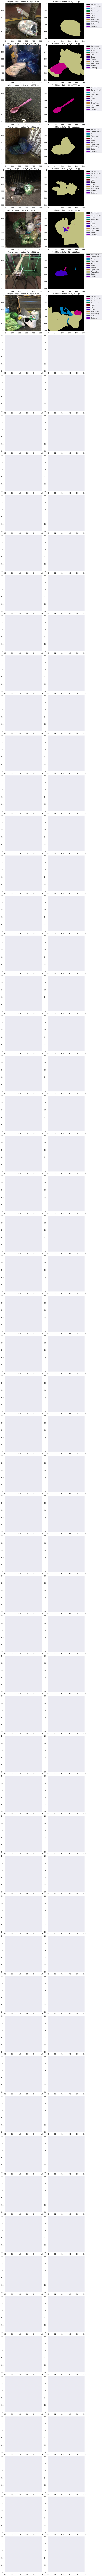

In [32]:
plot_examples(mode="test", batch_id=0, dataloaer=test_loader)

In [21]:
from matplotlib.patches import Patch

In [23]:
import webcolors

In [29]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch

#!pip install webcolors
import webcolors

import wandb

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.11.0+cu102
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1
